# Import Packages

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from scipy.stats import chi2_contingency

# Read in Data

In [51]:
data_path = os.path.join('..', 'data', 'raw', 'pizza_data.csv')
pizza_data = pd.read_csv(data_path)

In [52]:
# View data
pizza_data.head()

,cust_id,condition,order_conv,num_item,order_total,session_duration
0,1,0,0.0,0.0,0.00,6.00
1,2,0,0.0,0.0,0.00,6.00
2,3,1,1.0,9.0,11.45,0.57
3,4,0,1.0,9.0,10.00,0.50
4,5,0,0.0,0.0,0.00,6.00


In [53]:
# Check data types
pizza_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cust_id           4000 non-null   int64  
 1   condition         4000 non-null   int64  
 2   order_conv        4000 non-null   float64
 3   num_item          4000 non-null   float64
 4   order_total       4000 non-null   float64
 5   session_duration  4000 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 187.6 KB


In [54]:
# Update order_conv and condition to categorical variable
pizza_data[['order_conv', 'condition']] = pizza_data[['order_conv', 'condition']].astype('category')

In [55]:
# Confirm datatype updates
pizza_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   cust_id           4000 non-null   int64   
 1   condition         4000 non-null   category
 2   order_conv        4000 non-null   category
 3   num_item          4000 non-null   float64 
 4   order_total       4000 non-null   float64 
 5   session_duration  4000 non-null   float64 
dtypes: category(2), float64(3), int64(1)
memory usage: 133.2 KB


### Numerical descriptives

In [68]:
pizza_data.describe()

,cust_id,num_item,order_total,session_duration
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,2000.500000,3.418750,10.544165,7.344170
std,1154.844867,4.406047,16.771291,9.848544
min,1.000000,0.000000,0.000000,0.500000
25%,1000.750000,0.000000,0.000000,0.670000
50%,2000.500000,0.000000,0.000000,6.000000
75%,3000.250000,7.000000,12.185000,8.685000
max,4000.000000,13.000000,136.270000,85.140000


# Outcome Variable

### Random assignment produced 2053 customers in the control condition and 1947 customers in the experimental condition.

In [56]:
pizza_data['condition'].value_counts()

condition
0    2053
1    1947
Name: count, dtype: int64

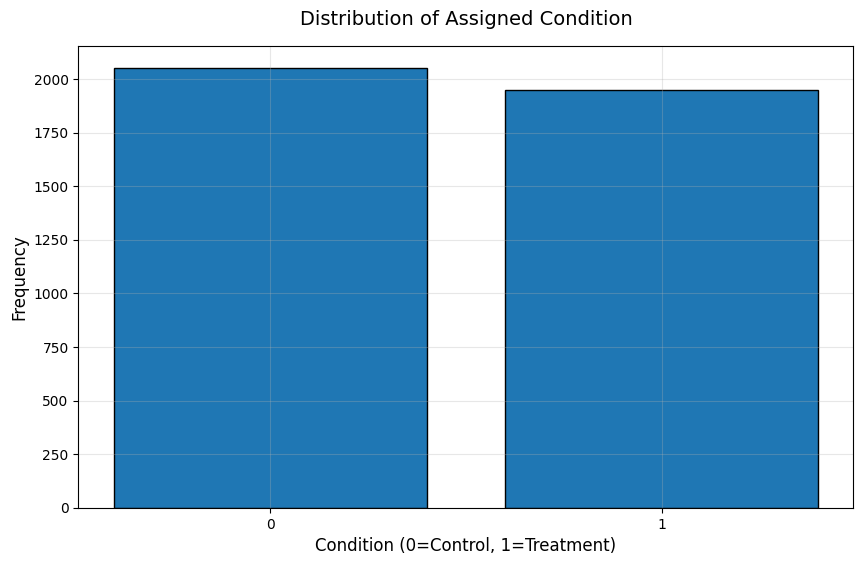

In [57]:
# Confirm 50/50 split
plt.figure(figsize=(10, 6))
plt.bar(['0', '1'], 
        pizza_data['condition'].value_counts().sort_index(),
        edgecolor='black')
plt.title('Distribution of Assigned Condition', fontsize=14, pad=15)
plt.xlabel('Condition (0=Control, 1=Treatment)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)

## Sale conversion rate

### Customers in the experimental condition were significantly more likely to make a purchase compared to treatment condition.

In [70]:
def chi_square_analysis(data, var1='condition', var2='order_conv'):
    # Create contingency table
    contingency = pd.crosstab(data[var1], data[var2])
    
    # Calculate percentages
    percentages = pd.crosstab(data[var1], data[var2], normalize='index') * 100
    
    # Perform chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency)
    
    # Calculate effect sizes
    n = contingency.sum().sum()
    min_dim = min(contingency.shape) - 1
    cramer_v = np.sqrt(chi2 / (n * min_dim))
    phi = np.sqrt(chi2 / n) if contingency.shape == (2, 2) else None
    
    # Print results
    print("Chi-square Test Results")
    print("-" * 50)
    
    print("\nContingency Table (Counts):")
    print(contingency)
    
    print("\nPercentages by Condition:")
    print(percentages.round(2))
    
    # Print detailed percentages for each group
    print("\nDetailed Conversion Rates:")
    for condition in [0, 1]:
        group_data = data[data[var1] == condition]
        total = len(group_data)
        converted = group_data[var2].astype('int').sum()
        rate = (converted / total) * 100
        
        group_name = "Treatment" if condition == 1 else "Control"
        print(f"\n{group_name} Group (condition = {condition}):")
        print(f"Total samples: {total}")
        print(f"Conversions: {converted}")
        print(f"Conversion rate: {rate:.2f}%")
    
    print("\nTest Statistics:")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Degrees of freedom: {dof}")
    
    print("\nEffect Sizes:")
    print(f"Cramer's V: {cramer_v:.4f}")
    if phi is not None:
        print(f"Phi coefficient: {phi:.4f}")
    
    # Effect size interpretation
    print("\nEffect Size Interpretation:")
    if cramer_v < 0.1:
        print("Cramer's V: Negligible effect")
    elif cramer_v < 0.3:
        print("Cramer's V: Small effect")
    elif cramer_v < 0.5:
        print("Cramer's V: Medium effect")
    else:
        print("Cramer's V: Large effect")
    
    # Calculate absolute difference in conversion rates
    conv_rates = percentages[1]  # Assuming 1 is the conversion column
    rate_difference = abs(conv_rates[1] - conv_rates[0])
    
    print(f"\nAbsolute Difference in Conversion Rates: {rate_difference:.2f} percentage points")
    
    # Statistical significance interpretation
    print("\nSignificance:")
    if p_value < 0.05:
        print(f"Statistically significant difference (p = {p_value:.4f})")
    else:
        print(f"No statistically significant difference (p = {p_value:.4f})")
    
    return {
        'chi2': chi2,
        'p_value': p_value,
        'dof': dof,
        'cramer_v': cramer_v,
        'phi': phi,
        'contingency': contingency,
        'percentages': percentages,
        'rate_difference': rate_difference
    }

# Run the analysis
results = chi_square_analysis(pizza_data)  

Chi-square Test Results
--------------------------------------------------

Contingency Table (Counts):
order_conv   0.0   1.0
condition             
0           1445   608
1            617  1330

Percentages by Condition:
order_conv    0.0    1.0
condition               
0           70.38  29.62
1           31.69  68.31

Detailed Conversion Rates:

Control Group (condition = 0):
Total samples: 2053
Conversions: 608
Conversion rate: 29.62%

Treatment Group (condition = 1):
Total samples: 1947
Conversions: 1330
Conversion rate: 68.31%

Test Statistics:
Chi-square statistic: 597.5288
p-value: 0.0000
Degrees of freedom: 1

Effect Sizes:
Cramer's V: 0.3865
Phi coefficient: 0.3865

Effect Size Interpretation:
Cramer's V: Medium effect

Absolute Difference in Conversion Rates: 38.70 percentage points

Significance:
Statistically significant difference (p = 0.0000)


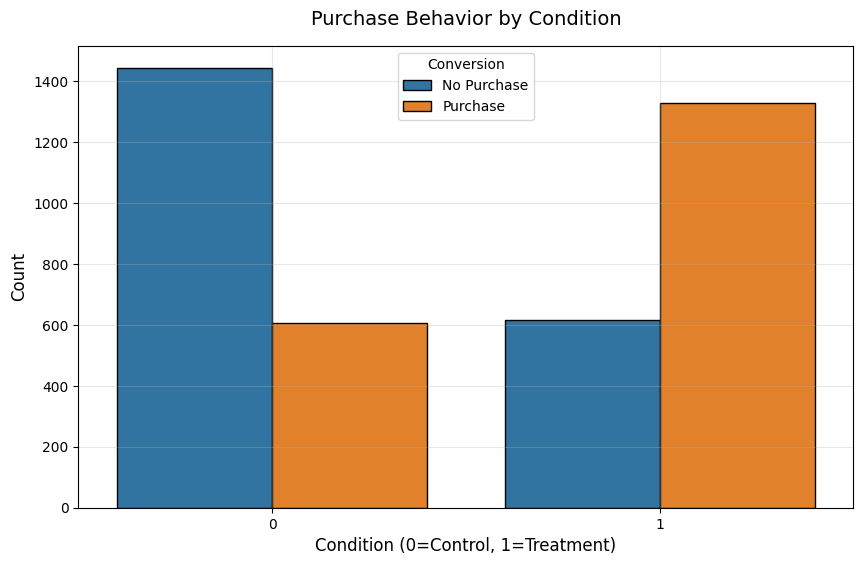

In [71]:
# Site condition by order status
plt.figure(figsize=(10, 6))
sns.countplot(data=pizza_data, 
              x='condition', 
              hue='order_conv',
              edgecolor='black')

plt.title('Purchase Behavior by Condition', fontsize=14, pad=15)
plt.xlabel('Condition (0=Control, 1=Treatment)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Conversion', labels=['No Purchase', 'Purchase'])
plt.grid(True, alpha=0.3)
plt.show()

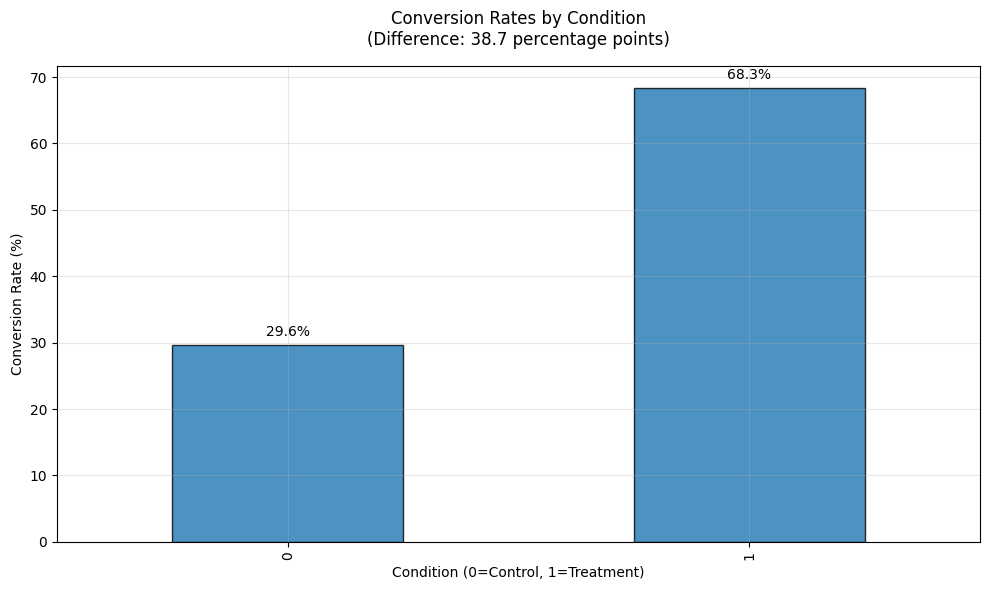

In [72]:
def plot_conversion_rates(results):
    """
    Create visualization of conversion rates
    """
    plt.figure(figsize=(10, 6))
    
    # Plot percentages
    ax = results['percentages'][1].plot(
        kind='bar',
        edgecolor='black',
        alpha=0.8
    )
    
    plt.title('Conversion Rates by Condition\n' + 
             f"(Difference: {results['rate_difference']:.1f} percentage points)",
             pad=15)
    plt.xlabel('Condition (0=Control, 1=Treatment)')
    plt.ylabel('Conversion Rate (%)')
    plt.grid(True, alpha=0.3)
    
    # Add percentage labels
    for i, v in enumerate(results['percentages'][1]):
        ax.text(i, v + 1, f'{v:.1f}%',
                ha='center',
                va='bottom')
    
    plt.tight_layout()
    plt.show()

# Show visualization
plot_conversion_rates(results)

# Univariate Tests

## Numerical Features

In [58]:
# Run loop to see all numerical features by outcome
def plot_numerical_by_condition(data, numeric_cols):
    """
    Plot numerical distributions by condition and calculate effect sizes
    """
    from scipy import stats
    
    def cohens_d(group1, group2):
        """Calculate Cohen's d effect size"""
        n1, n2 = len(group1), len(group2)
        var1, var2 = group1.var(), group2.var()
        
        # Pooled standard deviation
        pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
        
        # Cohen's d
        return (group1.mean() - group2.mean()) / pooled_se
    
    def eta_squared(group1, group2):
        """Calculate eta-squared effect size"""
        # Calculate sum of squares between groups
        grand_mean = np.mean(np.concatenate([group1, group2]))
        ss_between = (len(group1) * (np.mean(group1) - grand_mean)**2 + 
                     len(group2) * (np.mean(group2) - grand_mean)**2)
        
        # Calculate total sum of squares
        ss_total = np.sum((group1 - grand_mean)**2) + np.sum((group2 - grand_mean)**2)
        
        return ss_between / ss_total
    
    # Loop through each numerical column
    for col in numeric_cols:
        # Create figure
        plt.figure(figsize=(12, 6))
        
        # Get data for each condition
        control_data = data[data['condition'] == 0][col]
        treatment_data = data[data['condition'] == 1][col]
        
        # Create histogram
        plt.hist([control_data, treatment_data],
                label=['Control (0)', 'Treatment (1)'],
                bins=50,
                alpha=0.7,
                edgecolor='black')
        
        # Add labels and title
        plt.title(f'Distribution of {col} by Condition', fontsize=14, pad=15)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Calculate effect sizes
        d = cohens_d(control_data, treatment_data)
        eta_sq = eta_squared(control_data, treatment_data)
        
        # Add summary statistics
        for condition, data_group in zip([0, 1], [control_data, treatment_data]):
            stats_desc = data_group.describe()
            stats_text = (
                f'Condition {condition}:\n'
                f'n: {stats_desc["count"]:.0f}\n'
                f'Mean: {stats_desc["mean"]:.2f}\n'
                f'Median: {stats_desc["50%"]:.2f}\n'
                f'Std: {stats_desc["std"]:.2f}'
            )
            plt.text(0.95 if condition else 0.05, 0.95,
                    stats_text,
                    transform=plt.gca().transAxes,
                    verticalalignment='top',
                    horizontalalignment='right' if condition else 'left',
                    bbox=dict(boxstyle='round',
                             facecolor='white',
                             alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        # Statistical tests and effect sizes
        t_stat, p_val = stats.ttest_ind(control_data, treatment_data)
        
        print(f"\nResults for {col}:")
        print("-" * 50)
        print(f"T-test results:")
        print(f"t-statistic: {t_stat:.4f}")
        print(f"p-value: {p_val:.4f}")
        
        print("\nEffect Sizes:")
        print(f"Cohen's d: {d:.4f}")
        print(f"Eta-squared: {eta_sq:.4f}")
        
        # Effect size interpretation
        print("\nEffect Size Interpretation:")
        # Cohen's d interpretation
        if abs(d) < 0.2:
            print("Cohen's d: Negligible effect")
        elif abs(d) < 0.5:
            print("Cohen's d: Small effect")
        elif abs(d) < 0.8:
            print("Cohen's d: Medium effect")
        else:
            print("Cohen's d: Large effect")
            
        # Eta-squared interpretation
        if eta_sq < 0.01:
            print("Eta-squared: Negligible effect")
        elif eta_sq < 0.06:
            print("Eta-squared: Small effect")
        elif eta_sq < 0.14:
            print("Eta-squared: Medium effect")
        else:
            print("Eta-squared: Large effect")
        
        print("-" * 50)


### Number of Items

#### Customers in the treatment condition who placed orders had statistically significant higher number of items on average than customers who placed orders in the control condition.

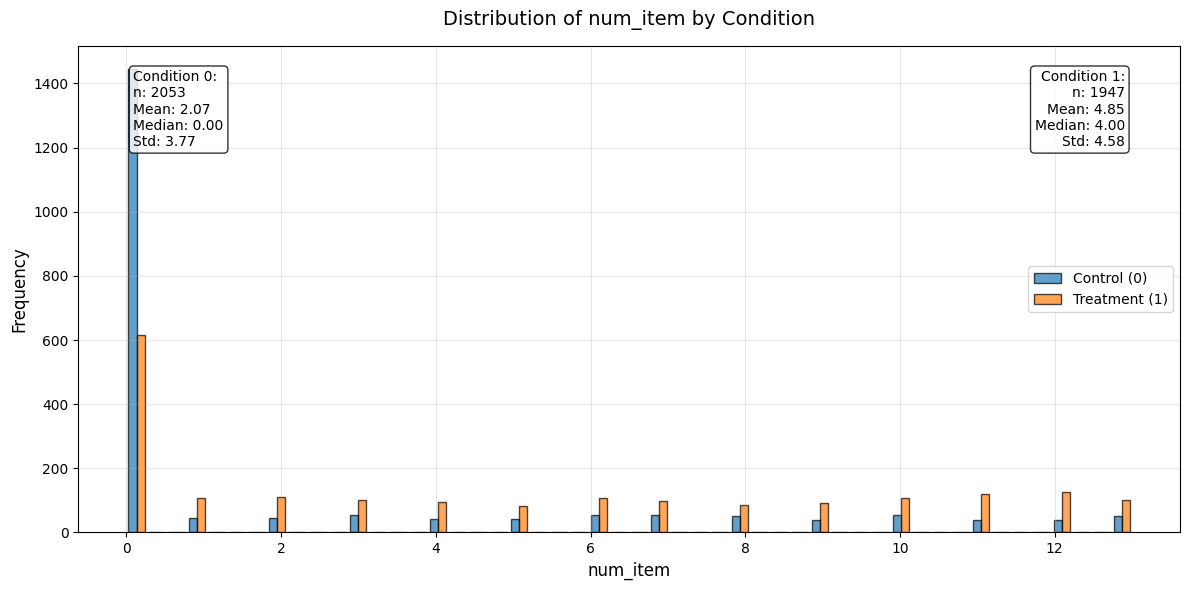


Results for num_item:
--------------------------------------------------
T-test results:
t-statistic: -21.0210
p-value: 0.0000

Effect Sizes:
Cohen's d: -0.6650
Eta-squared: 0.0995

Effect Size Interpretation:
Cohen's d: Medium effect
Eta-squared: Medium effect
--------------------------------------------------


In [59]:
numeric_columns = ["num_item"]
plot_numerical_by_condition(pizza_data, numeric_columns)

### Order Total

#### Customers in the treatment condition who placed orders had statistically significant higher order totals on average than customers who placed orders in the control condition.

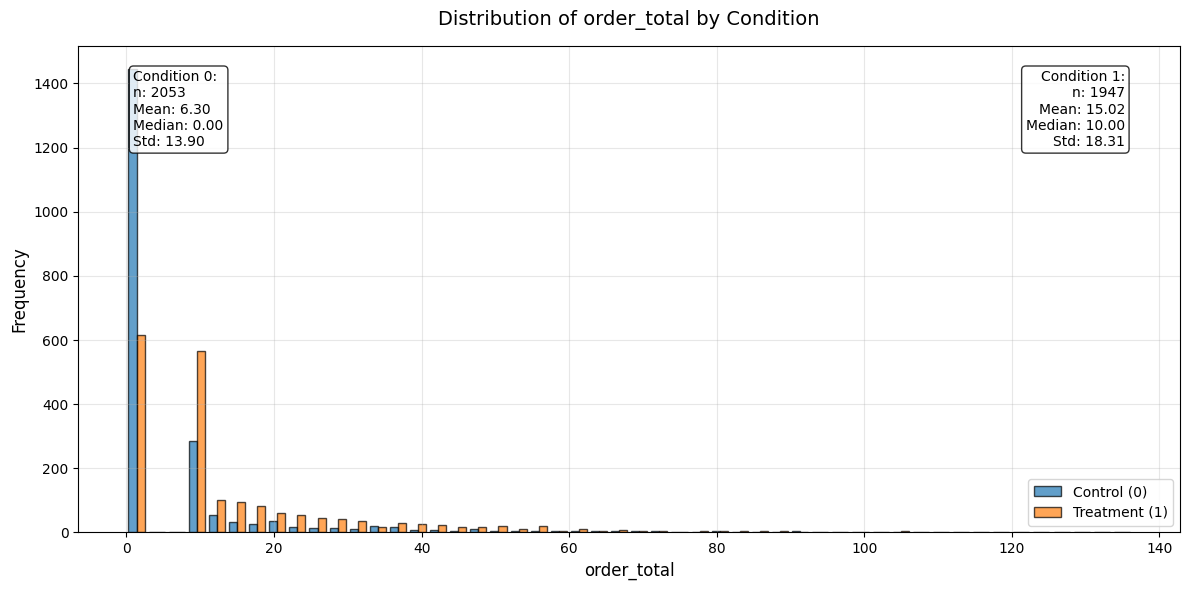


Results for order_total:
--------------------------------------------------
T-test results:
t-statistic: -17.0261
p-value: 0.0000

Effect Sizes:
Cohen's d: -0.5386
Eta-squared: 0.0676

Effect Size Interpretation:
Cohen's d: Medium effect
Eta-squared: Medium effect
--------------------------------------------------


In [60]:
numeric_columns = ["order_total"]
plot_numerical_by_condition(pizza_data, numeric_columns)

### Site Navigation Time

#### Customers in the treatment condition spent a statistically significant lower amount of time on average navigating the site compared to customers in the control condition.

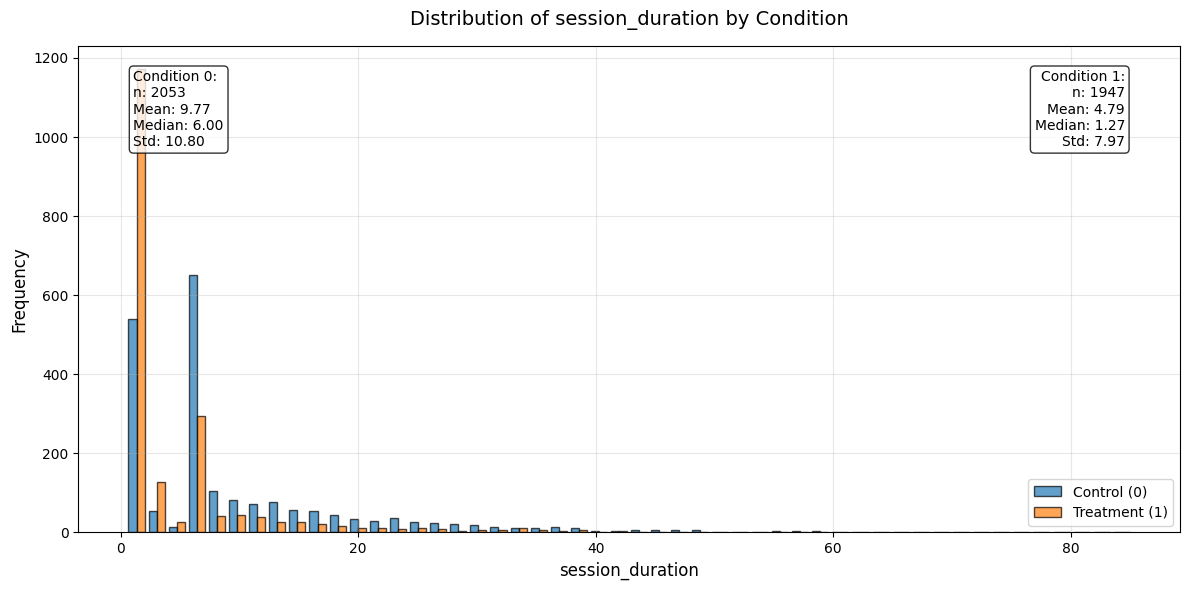


Results for session_duration:
--------------------------------------------------
T-test results:
t-statistic: 16.5053
p-value: 0.0000

Effect Sizes:
Cohen's d: 0.5221
Eta-squared: 0.0638

Effect Size Interpretation:
Cohen's d: Medium effect
Eta-squared: Medium effect
--------------------------------------------------


In [61]:
numeric_columns = ["session_duration"]
plot_numerical_by_condition(pizza_data, numeric_columns)

# Multivariate Tests

In [76]:
# Plot and analyze numerical variables by condition and purchase status

def plot_numerical_by_groups(data, numeric_cols):
    from scipy import stats
    
    def cohens_f(groups):
        """Calculate Cohen's f effect size for multiple groups"""
        # Calculate grand mean
        all_data = np.concatenate([group for group in groups])
        grand_mean = np.mean(all_data)
        
        # Calculate between-groups sum of squares
        n_groups = len(groups)
        ss_between = sum(len(group) * (np.mean(group) - grand_mean)**2 
                        for group in groups)
        
        # Calculate within-groups sum of squares
        ss_within = sum(sum((x - np.mean(group))**2) 
                       for group, x in zip(groups, groups))
        
        # Calculate Cohen's f
        f = np.sqrt(ss_between / ss_within)
        return f

    # Loop through each numerical column
    for col in numeric_cols:
        # Create figure
        plt.figure(figsize=(15, 8))
        
        # Get data for each group
        control_purchase = data[(data['condition'] == 0) & (data['order_conv'] == 1)][col]
        control_no_purchase = data[(data['condition'] == 0) & (data['order_conv'] == 0)][col]
        treatment_purchase = data[(data['condition'] == 1) & (data['order_conv'] == 1)][col]
        treatment_no_purchase = data[(data['condition'] == 1) & (data['order_conv'] == 0)][col]
        
        # Create histogram
        plt.hist([control_no_purchase, control_purchase, 
                 treatment_no_purchase, treatment_purchase],
                label=['Control-No Purchase', 'Control-Purchase',
                       'Treatment-No Purchase', 'Treatment-Purchase'],
                bins=50,
                alpha=0.7,
                edgecolor='black')
        
        # Add labels and title
        plt.title(f'Distribution of {col} by Condition and Purchase Status', 
                 fontsize=14, pad=15)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Add summary statistics for each group
        groups = [
            ('Control-No Purchase', control_no_purchase, 0.05, 'left'),
            ('Control-Purchase', control_purchase, 0.35, 'left'),
            ('Treatment-No Purchase', treatment_no_purchase, 0.65, 'right'),
            ('Treatment-Purchase', treatment_purchase, 0.95, 'right')
        ]
        
        for label, group_data, pos, align in groups:
            stats_desc = group_data.describe()
            stats_text = (
                f'{label}:\n'
                f'n: {stats_desc["count"]:.0f}\n'
                f'Mean: {stats_desc["mean"]:.2f}\n'
                f'Median: {stats_desc["50%"]:.2f}\n'
                f'Std: {stats_desc["std"]:.2f}'
            )
            plt.text(pos, 0.95,
                    stats_text,
                    transform=plt.gca().transAxes,
                    verticalalignment='top',
                    horizontalalignment=align,
                    bbox=dict(boxstyle='round',
                             facecolor='white',
                             alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        # Statistical tests
        print(f"\nResults for {col}:")
        print("-" * 50)
        
        # Two-way ANOVA
        from statsmodels.stats.anova import anova_lm
        from statsmodels.formula.api import ols
        
        # Prepare data for ANOVA
        model = ols(f'{col} ~ C(condition) + C(order_conv) + C(condition):C(order_conv)', 
                   data=data).fit()
        anova_table = anova_lm(model, typ=2)
        
        print("\nTwo-way ANOVA results:")
        print(anova_table)
        
        # Effect sizes
        groups_list = [control_no_purchase, control_purchase,
                      treatment_no_purchase, treatment_purchase]
        f_statistic = cohens_f(groups_list)
        
        print("\nEffect Sizes:")
        print(f"Cohen's f: {f_statistic:.4f}")
        
        # Effect size interpretation
        print("\nEffect Size Interpretation:")
        if f_statistic < 0.1:
            print("Cohen's f: Negligible effect")
        elif f_statistic < 0.25:
            print("Cohen's f: Small effect")
        elif f_statistic < 0.4:
            print("Cohen's f: Medium effect")
        else:
            print("Cohen's f: Large effect")
        
        # Post-hoc tests
        from scipy.stats import tukey_hsd
        
        # Create arrays for Tukey's test
        values = np.concatenate(groups_list)
        groups = np.concatenate([
            np.repeat('Control-No Purchase', len(control_no_purchase)),
            np.repeat('Control-Purchase', len(control_purchase)),
            np.repeat('Treatment-No Purchase', len(treatment_no_purchase)),
            np.repeat('Treatment-Purchase', len(treatment_purchase))
        ])
        
        # Perform Tukey's test
        tukey_results = tukey_hsd(values, groups)
        
        print("\nTukey's HSD Post-hoc Test:")
        print(tukey_results)
        
        print("-" * 50)


## Condition x. Purchase x. Order Total

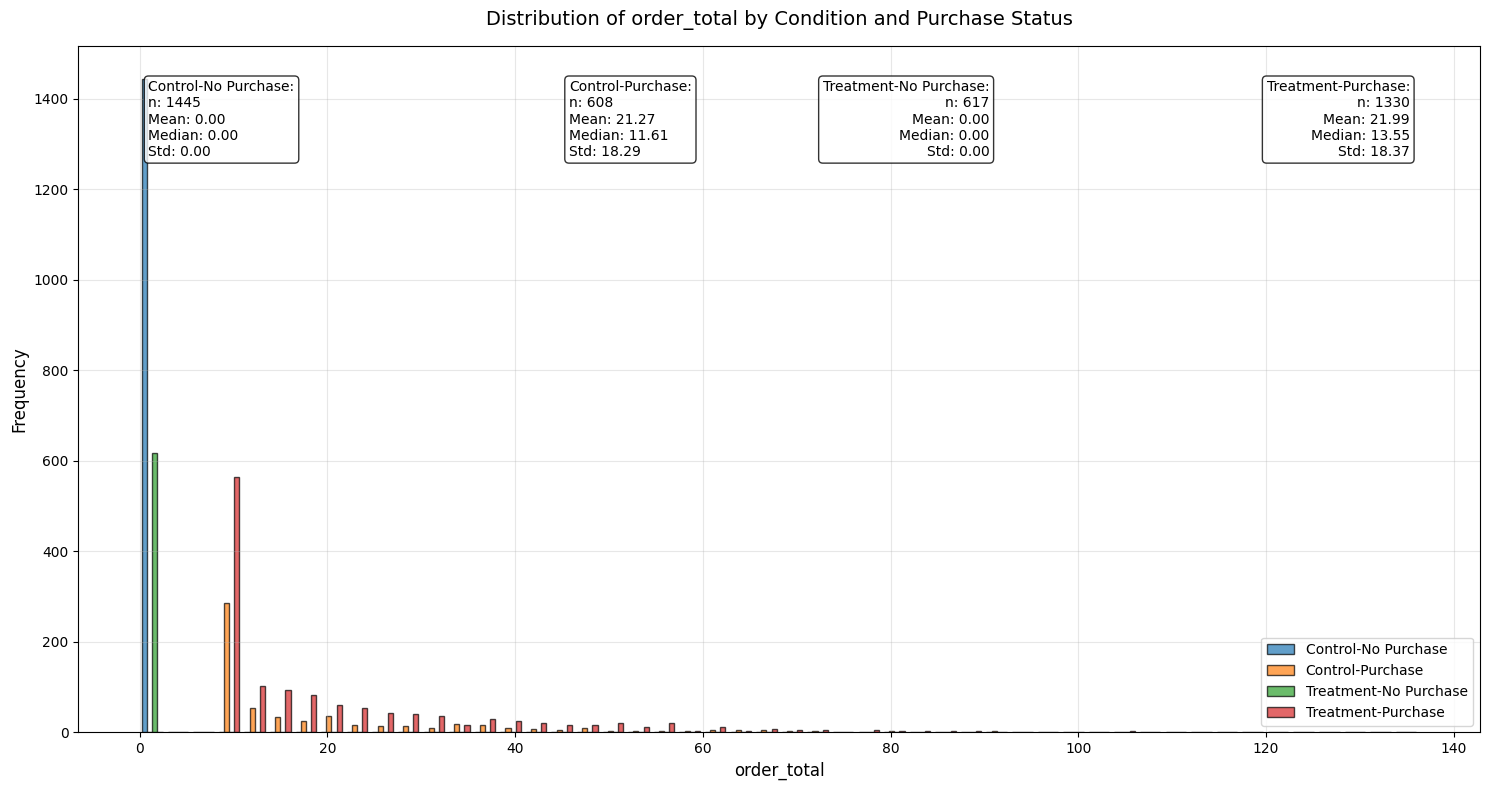


Results for order_total:
--------------------------------------------------

Two-way ANOVA results:
                                   sum_sq      df            F    PR(>F)
C(condition)                   107.383006     1.0     0.658706  0.417066
C(order_conv)               397234.374355     1.0  2436.704165  0.000000
C(condition):C(order_conv)     111.275219     1.0     0.682581  0.408749
Residual                    651432.612337  3996.0          NaN       NaN

Effect Sizes:
Cohen's f: 0.8525

Effect Size Interpretation:
Cohen's f: Large effect


TypeError: ufunc 'isinf' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [77]:
numeric_columns = ['order_total']
plot_numerical_by_groups(pizza_data, numeric_columns)

## Condition x. Purhcase x. Session Duration

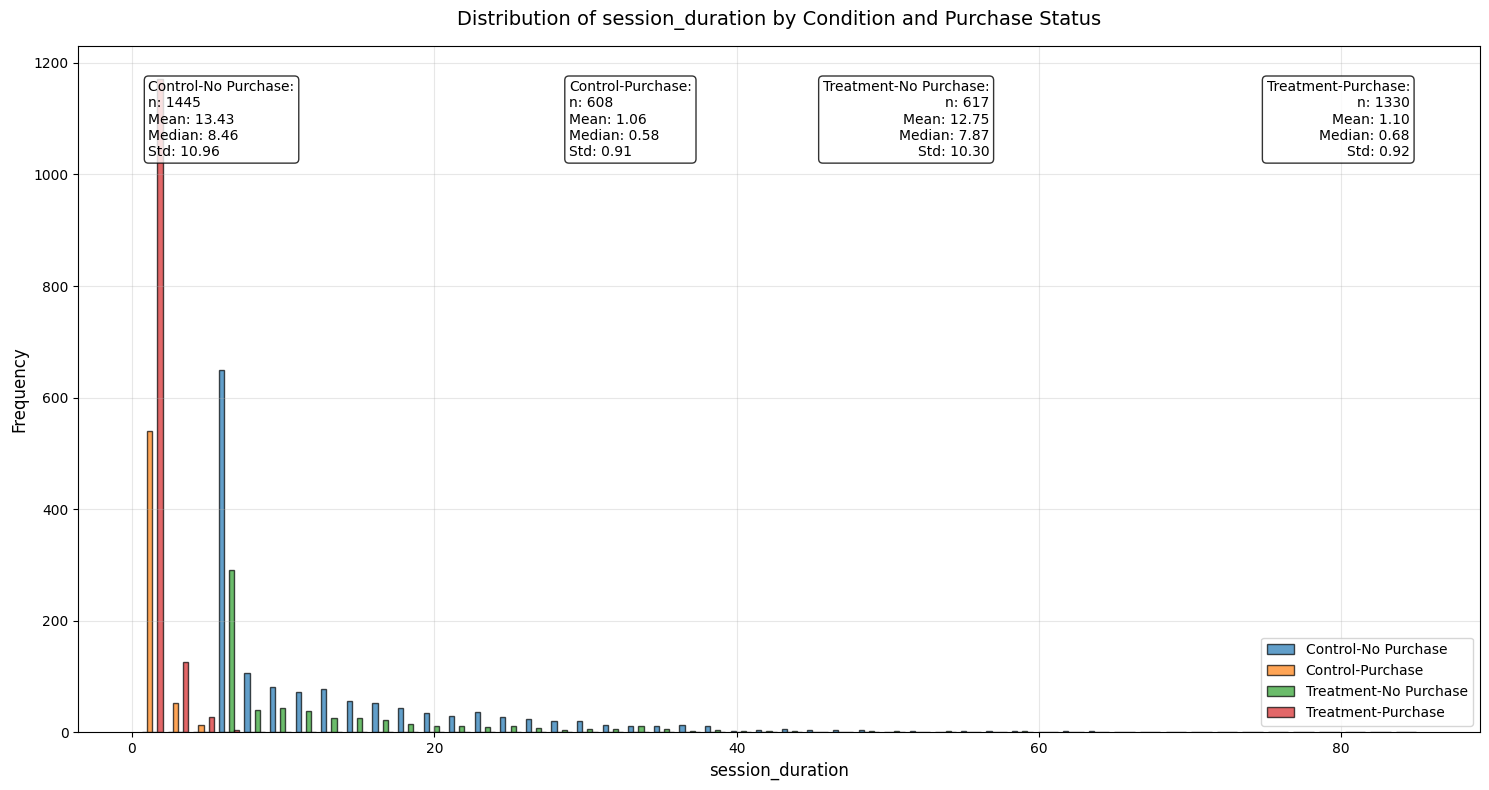


Results for session_duration:
--------------------------------------------------

Two-way ANOVA results:
                                   sum_sq      df            F    PR(>F)
C(condition)                    92.193654     1.0     1.531600  0.215945
C(order_conv)               122488.020702     1.0  2034.875470  0.000000
C(condition):C(order_conv)     109.556602     1.0     1.820048  0.177384
Residual                    240536.650991  3996.0          NaN       NaN

Effect Sizes:
Cohen's f: 0.7827

Effect Size Interpretation:
Cohen's f: Large effect


TypeError: ufunc 'isinf' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [78]:
numeric_columns = ['session_duration']
plot_numerical_by_groups(pizza_data, numeric_columns)

## Condition x. Purhcase x. Number of Items

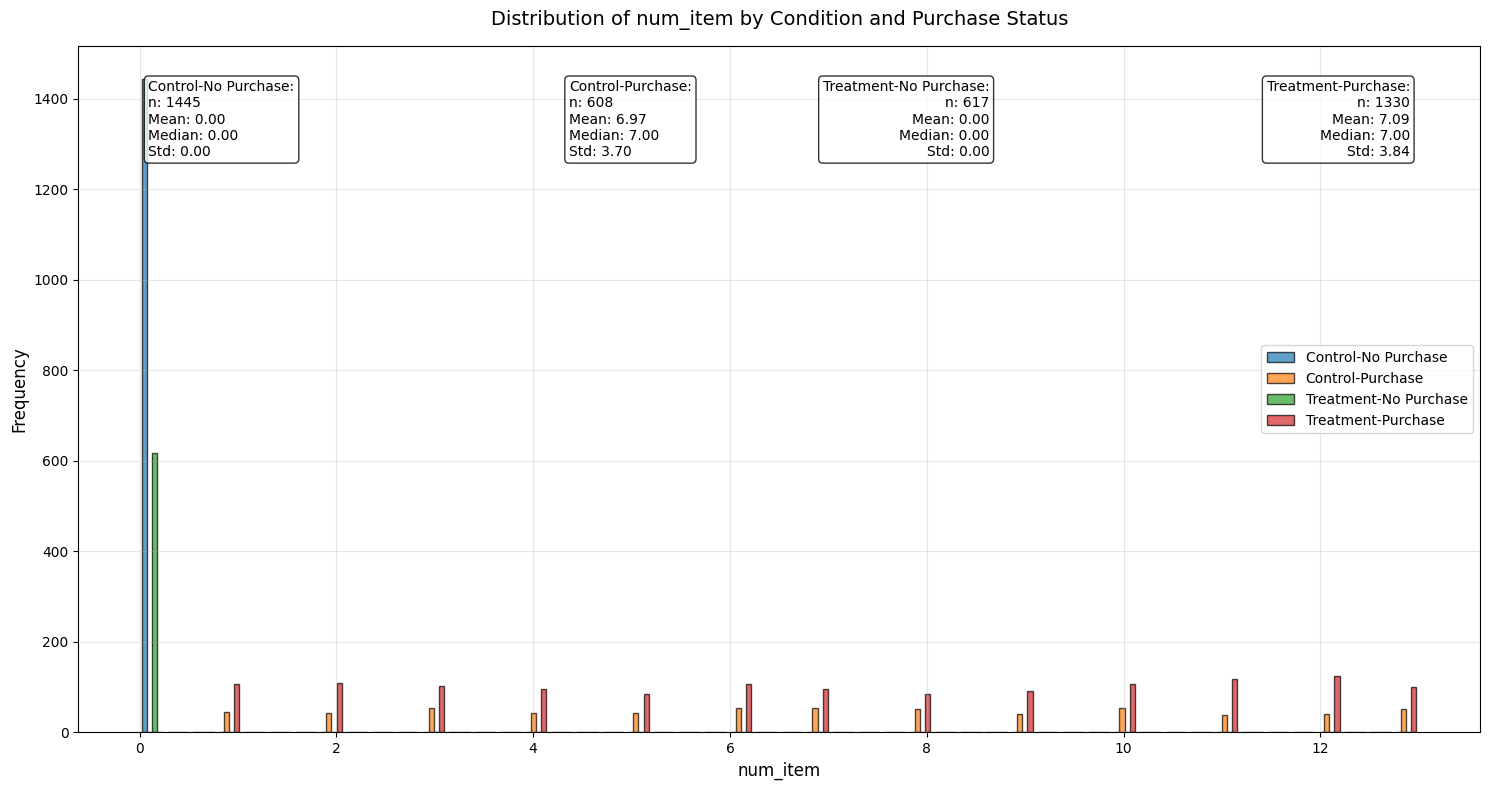


Results for num_item:
--------------------------------------------------

Two-way ANOVA results:
                                  sum_sq      df            F    PR(>F)
C(condition)                    2.965568     1.0     0.424977  0.514502
C(order_conv)               42019.124928     1.0  6021.496930  0.000000
C(condition):C(order_conv)      3.073058     1.0     0.440381  0.506977
Residual                    27884.830827  3996.0          NaN       NaN

Effect Sizes:
Cohen's f: 1.3357

Effect Size Interpretation:
Cohen's f: Large effect


TypeError: ufunc 'isinf' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [79]:
numeric_columns = ['num_item']
plot_numerical_by_groups(pizza_data, numeric_columns)